In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [20]:
# ==========================================
# 1. Data Loading and SQL Processing
# ==========================================
print("--- Step 1: Loading Data and SQL Processing ---")

# Updated file path to relative path since the file is in the same directory
file_path = "Shared_Micromobility_Vehicle_Trips_(2018-2022)_20251130.csv"

# Load the csv (reading a sample first to identify types is good practice, but we load all here)
# Given the size (900k rows), this might take a moment.
df_raw = pd.read_csv(file_path)

# Convert columns to appropriate names for SQL compatibility (remove spaces/parentheses)
# Example: "Year (US/Central)" -> "year_us_central"
df_raw.columns = [c.lower().replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_') for c in df_raw.columns]

# FIX 1: The CSV column "ID" becomes "id" after lower(), but the SQL query expects "trip_id".
if 'id' in df_raw.columns:
    df_raw.rename(columns={'id': 'trip_id'}, inplace=True)

# FIX 2: The CSV column "Year (US/Central)" becomes "year_us_central", but SQL query expects "year".
# We explicitly rename it here to avoid the "no such column: year" error.
if 'year_us_central' in df_raw.columns:
    df_raw.rename(columns={'year_us_central': 'year'}, inplace=True)

# --- DEBUGGING SECTION ---
# This helps identify why 0 records are returned.
print("Columns in dataset:", df_raw.columns.tolist())
if 'year' in df_raw.columns:
    print("Years found in dataset (raw):", df_raw['year'].unique())
    # FIX for "2,021": Remove commas before converting to numeric
    if df_raw['year'].dtype == 'object':
        df_raw['year'] = df_raw['year'].astype(str).str.replace(',', '')
    
    # Force Year to be numeric (handle potential string/float mismatch)
    df_raw['year'] = pd.to_numeric(df_raw['year'], errors='coerce')
    print("Years after cleaning:", df_raw['year'].unique())

if 'month' in df_raw.columns:
    print("Months found in dataset (sample):", df_raw['month'].unique()[:12])
    # Force Month to be numeric
    df_raw['month'] = pd.to_numeric(df_raw['month'], errors='coerce')
# -------------------------

# Create an in-memory SQLite database to satisfy the "SQL" course requirement
conn = sqlite3.connect(':memory:')
df_raw.to_sql('trips', conn, index=False, if_exists='replace')

# SQL QUERY: Filter for date range (2021-10 to 2022-10) and remove unreasonable data
# Logic: 
# 1. Date range filter. Note the extra parentheses around the date logic to ensure correct precedence.
#    ((Year A) OR (Year B)) AND (Other Constraints)
# 2. Trip distance > 100 meters (remove micro-movements).
# 3. Trip duration between 60 seconds and 7200 seconds (2 hours) to remove errors.
# UPDATE: User requested to keep majority of data. Relaxing date and distance/duration constraints.
query = """
SELECT 
    trip_id, device_id, vehicle_type, trip_duration, trip_distance, 
    start_time, month, hour, day_of_week, 
    council_district_start, year, census_tract_start
FROM trips
WHERE 
    year IN (2021, 2022) -- Relaxed: Keep ALL data from 2021 and 2022, ignoring specific month limits
    AND trip_duration > 0 -- Relaxed: Keep all trips with positive duration
    AND trip_duration < 86400 -- Relaxed: Keep trips under 24 hours
    AND trip_distance > 0 -- Relaxed: Keep all trips with positive distance
"""

df = pd.read_sql_query(query, conn)
print(f"Data filtered from {len(df_raw)} to {len(df)} records using SQL.")

--- Step 1: Loading Data and SQL Processing ---
Columns in dataset: ['trip_id', 'device_id', 'vehicle_type', 'trip_duration', 'trip_distance', 'start_time', 'end_time', 'modified_date', 'month', 'hour', 'day_of_week', 'council_district_start', 'council_district_end', 'year', 'census_tract_start', 'census_tract_end', 'start_time_us_central', 'end_time_us_central']
Years found in dataset (raw): ['2,021' '2,022']
Years after cleaning: [2021 2022]
Months found in dataset (sample): [10 11 12  1  2  3  4]
Data filtered from 952664 to 889552 records using SQL.



--- Step 2: Exploratory Data Analysis ---
Ensuring numeric types for analysis columns...
Data count before cleaning: 889552
Data count after removing micro-trips (<60s or <100m): 889100


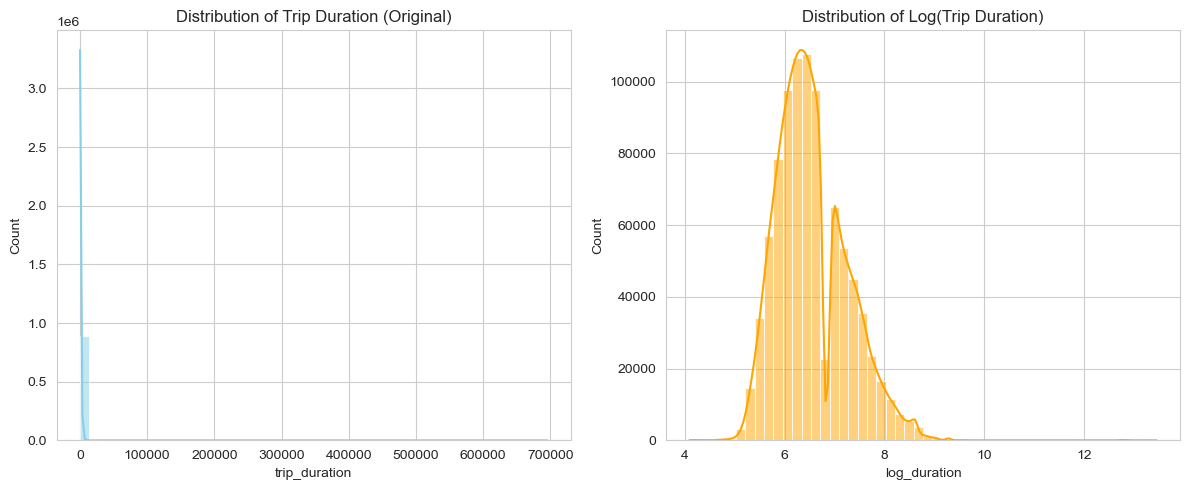

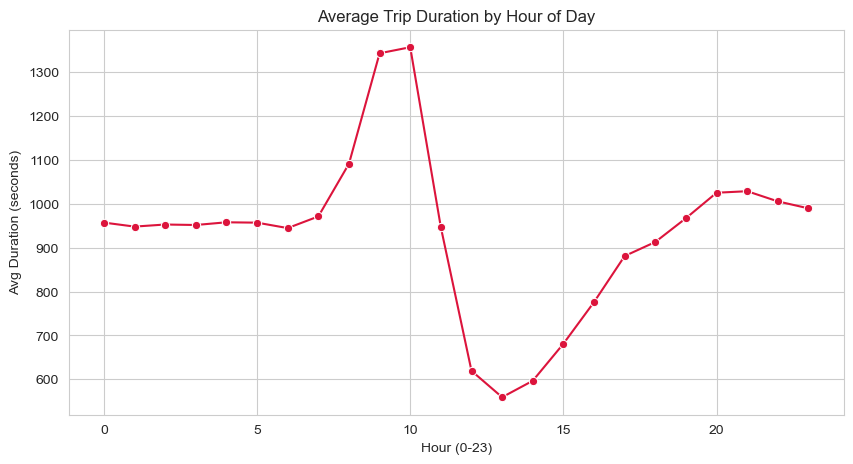

In [21]:
# ==========================================
# 2. Exploratory Data Analysis (EDA)
# ==========================================
print("\n--- Step 2: Exploratory Data Analysis ---")

# FIX: Force numeric types for critical columns.
# SQLite/Pandas roundtrip or raw CSV reading might have left these as objects/strings.
print("Ensuring numeric types for analysis columns...")
for col in ['trip_duration', 'trip_distance', 'hour', 'day_of_week']:
    if col in df.columns:
        # AGGRESSIVE FIX: Always force string conversion, strip whitespace and commas, then convert to numeric
        # This prevents "1,200" being treated as NaN simply because dtype check failed or it wasn't strictly 'object'
        df[col] = df[col].astype(str).str.replace(',', '').str.strip()
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows where conversion failed (NaNs)
df = df.dropna(subset=['trip_duration', 'trip_distance'])

# --- DATA CLEANING BASED ON EDA ---
# As seen in the histograms, there is a massive spike near 0.
# We need to filter out micro-trips (likely errors, unlock/relock) to get a valid distribution.
print(f"Data count before cleaning: {len(df)}")
df = df[df['trip_duration'] >= 60]  # Remove trips less than 1 minute
df = df[df['trip_distance'] >= 100] # Remove trips less than 100 meters
print(f"Data count after removing micro-trips (<60s or <100m): {len(df)}")

# Feature Engineering
# Log transform duration because time data is usually right-skewed
df['log_duration'] = np.log(df['trip_duration'])

# Plot 1: Distribution of Trip Duration
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['trip_duration'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Trip Duration (Original)')
plt.subplot(1, 2, 2)
sns.histplot(df['log_duration'], bins=50, kde=True, color='orange')
plt.title('Distribution of Log(Trip Duration)')
plt.tight_layout()
plt.show()

# Plot 2: Average Duration by Hour of Day
hourly_stats = df.groupby('hour')['trip_duration'].mean().reset_index()
plt.figure(figsize=(10, 5))
sns.lineplot(data=hourly_stats, x='hour', y='trip_duration', marker='o', color='crimson')
plt.title('Average Trip Duration by Hour of Day')
plt.xlabel('Hour (0-23)')
plt.ylabel('Avg Duration (seconds)')
plt.show()




--- Step 3: Building Regression Models (OLS) & Inference ---
                            OLS Regression Results                            
Dep. Variable:           log_duration   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     810.4
Date:                Sun, 30 Nov 2025   Prob (F-statistic):               0.00
Time:                        17:53:10   Log-Likelihood:            -9.4193e+05
No. Observations:              888924   AIC:                         1.884e+06
Df Residuals:                  888883   BIC:                         1.884e+06
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

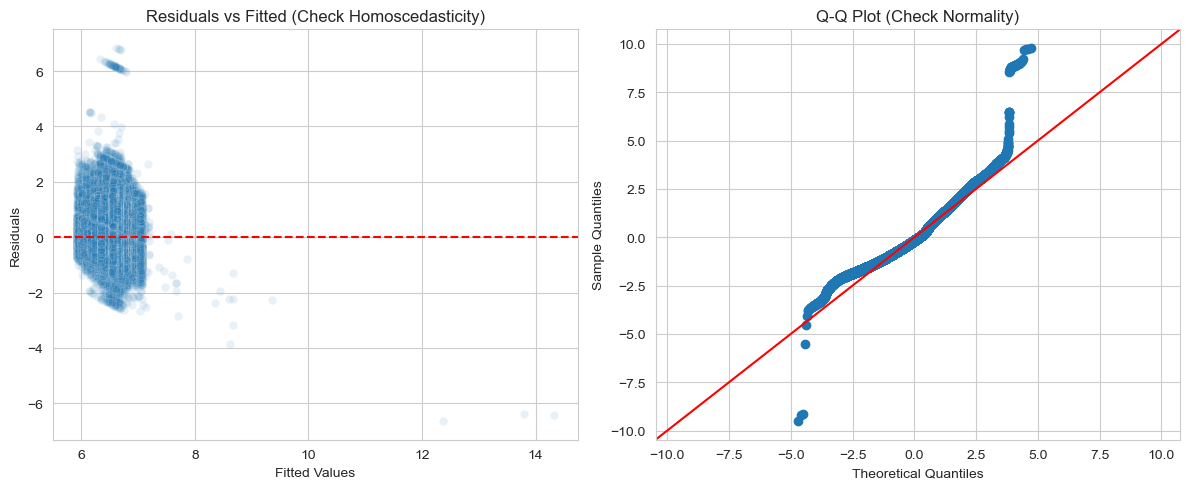

In [22]:
# ==========================================
# 3. OLS Regression & Inference
# ==========================================
print("\n--- Step 3: Building Regression Models (OLS) & Inference ---")

# Prepare data for regression
# We treat 'council_district_start' and 'day_of_week' as categorical
# Drop rows with missing values in relevant columns
reg_df = df.dropna(subset=['trip_distance', 'hour', 'day_of_week', 'council_district_start']).copy()

# Create dummy variables manually for clearer control or use formula interface
# Using statsmodels formula API automatically handles categorical variables with C()
formula = 'log_duration ~ trip_distance + C(hour) + C(day_of_week) + C(council_district_start)'

model_ols = smf.ols(formula=formula, data=reg_df).fit()

print(model_ols.summary())

# --- Model Checking ---
print("Conducting Model Checking...")

# Residual Analysis
residuals = model_ols.resid
fitted = model_ols.fittedvalues

plt.figure(figsize=(12, 5))

# Residuals vs Fitted
plt.subplot(1, 2, 1)
sns.scatterplot(x=fitted, y=residuals, alpha=0.1)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted (Check Homoscedasticity)')

# Q-Q Plot
plt.subplot(1, 2, 2)
sm.qqplot(residuals, line='45', fit=True, ax=plt.gca())
plt.title('Q-Q Plot (Check Normality)')
plt.tight_layout()
plt.show()



--- Step 4: Shrinkage Estimators (Ridge & LASSO) ---
Optimal Ridge Alpha: 100.0
Ridge MSE: 0.4813
Ridge R2: 0.0445
Optimal Lasso Alpha: 0.04797744151358863
Lasso MSE: 0.5019
Lasso Number of Features reduced to 0: 37


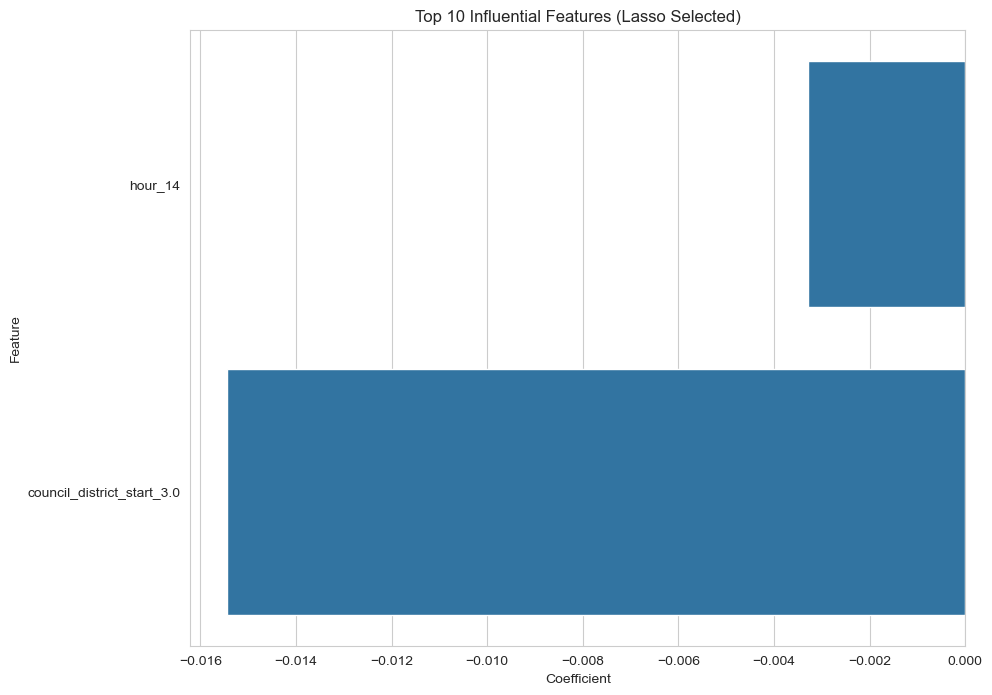

In [23]:
# ==========================================
# 4. Variable Selection & Shrinkage (Lasso/Ridge)
# ==========================================
print("\n--- Step 4: Shrinkage Estimators (Ridge & LASSO) ---")

# For Scikit-Learn, we need to manually create the design matrix (One-Hot Encoding)
# We will take a random sample to speed up computation if dataset is huge, 
# but for 900k rows, it's doable on modern RAM. Let's sample 50k for demonstration speed.
sample_df = reg_df.sample(n=50000, random_state=42)

# Define predictors (X) and target (y)
X_cols = ['trip_distance', 'hour', 'day_of_week', 'council_district_start']
X = pd.get_dummies(sample_df[X_cols], columns=['hour', 'day_of_week', 'council_district_start'], drop_first=True)
y = sample_df['log_duration']

# Standardization (Crucial for Ridge/Lasso)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# --- Ridge Regression ---
# Using RidgeCV to find optimal alpha
ridge_cv = RidgeCV(alphas=np.logspace(-2, 2, 10), scoring='neg_mean_squared_error')
ridge_cv.fit(X_train, y_train)
y_pred_ridge = ridge_cv.predict(X_test)

print(f"Optimal Ridge Alpha: {ridge_cv.alpha_}")
print(f"Ridge MSE: {mean_squared_error(y_test, y_pred_ridge):.4f}")
print(f"Ridge R2: {r2_score(y_test, y_pred_ridge):.4f}")

# --- LASSO Regression ---
# Using LassoCV for variable selection
lasso_cv = LassoCV(alphas=None, cv=5, random_state=42)
lasso_cv.fit(X_train, y_train)
y_pred_lasso = lasso_cv.predict(X_test)

print(f"Optimal Lasso Alpha: {lasso_cv.alpha_}")
print(f"Lasso MSE: {mean_squared_error(y_test, y_pred_lasso):.4f}")
print(f"Lasso Number of Features reduced to 0: {np.sum(lasso_cv.coef_ == 0)}")

# visualize coefficients for Lasso to see variable selection
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': lasso_cv.coef_})
coef_df = coef_df[coef_df['Coefficient'] != 0].sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(y='Feature', x='Coefficient', data=coef_df.head(10))
plt.title('Top 10 Influential Features (Lasso Selected)')
plt.show()




--- Step 5: Generalized Linear Models (GLM) ---
Aggregated Data Shape: (7343, 6)
                 Generalized Linear Model Regression Results                  
Dep. Variable:             trip_count   No. Observations:                 5857
Model:                            GLM   Df Residuals:                     5817
Model Family:                 Poisson   Df Model:                           39
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1954e+05
Date:                Sun, 30 Nov 2025   Deviance:                   2.1193e+05
Time:                        17:55:14   Pearson chi2:                 2.34e+05
No. Iterations:                     9   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
--------------------------

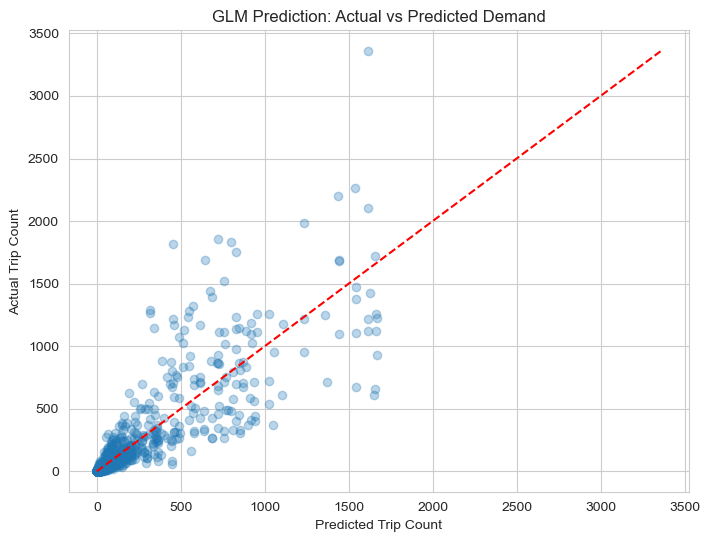


--- Analysis Complete ---


In [24]:
# ==========================================
# 5. Generalized Linear Models (GLM) - Poisson
# ==========================================
print("\n--- Step 5: Generalized Linear Models (GLM) ---")

# Problem Shift: Predicting the COUNT of trips (Demand) per hour per district
# Aggregating data
demand_df = df.groupby(['year', 'month', 'day_of_week', 'hour', 'council_district_start']).size().reset_index(name='trip_count')

# Convert categorical to string for statsmodels
demand_df['hour'] = demand_df['hour'].astype(str)
demand_df['day_of_week'] = demand_df['day_of_week'].astype(str)
demand_df['council_district_start'] = demand_df['council_district_start'].astype(str)

print(f"Aggregated Data Shape: {demand_df.shape}")

# Split into train/test (chronologically would be better for time series, but random is ok for basic GLM course req)
mask = np.random.rand(len(demand_df)) < 0.8
train_glm = demand_df[mask]
test_glm = demand_df[~mask]

# Poisson Regression Formula
# We want to predict 'trip_count' based on time and location
glm_formula = 'trip_count ~ C(hour) + C(day_of_week) + C(council_district_start)'

# Fit Poisson GLM
glm_poisson = smf.glm(formula=glm_formula, data=train_glm, family=sm.families.Poisson()).fit()

print(glm_poisson.summary())

# Check for Overdispersion (Variance > Mean)
# If Pearson chi2 / degrees of freedom > 1, strictly speaking we should use Negative Binomial
phi = glm_poisson.pearson_chi2 / glm_poisson.df_resid
print(f"\nDispersion Parameter (Phi): {phi:.4f}")

if phi > 1.5:
    print("Detected Overdispersion. Fitting Negative Binomial Model...")
    glm_nb = smf.glm(formula=glm_formula, data=train_glm, family=sm.families.NegativeBinomial()).fit()
    print(glm_nb.summary())
    final_model = glm_nb
else:
    final_model = glm_poisson

# Predict on test set
predictions = final_model.predict(test_glm)
plt.figure(figsize=(8, 6))
plt.scatter(predictions, test_glm['trip_count'], alpha=0.3)
plt.plot([0, test_glm['trip_count'].max()], [0, test_glm['trip_count'].max()], 'r--')
plt.xlabel('Predicted Trip Count')
plt.ylabel('Actual Trip Count')
plt.title('GLM Prediction: Actual vs Predicted Demand')
plt.show()

print("\n--- Analysis Complete ---")